We use pandas to import the data. See "IO Tools" and "Indexing and Selecting Data" from the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/index.html)

In [7]:
import pandas as pd

D=pd.read_csv("dpc-covid19-ita-regioni.csv",header=0)
print(D.dtypes)

data                           object
stato                          object
codice_regione                  int64
denominazione_regione          object
lat                           float64
long                          float64
ricoverati_con_sintomi          int64
terapia_intensiva               int64
totale_ospedalizzati            int64
isolamento_domiciliare          int64
totale_positivi                 int64
variazione_totale_positivi      int64
nuovi_positivi                  int64
dimessi_guariti                 int64
deceduti                        int64
totale_casi                     int64
tamponi                         int64
note_it                        object
note_en                        object
dtype: object


In [18]:
Lom = D.loc[D['codice_regione'].isin([6,3]),['data','denominazione_regione','totale_positivi','totale_ospedalizzati', 'deceduti']]
Lom = Lom.set_index(pd.to_datetime(Lom['data'],infer_datetime_format=True).dt.normalize())
Lom.tail(3)

,data,denominazione_regione,totale_positivi,totale_ospedalizzati,deceduti
data,,,,,
2020-04-08,2020-04-08T17:00:00,Lombardia,28545,12976,9722
2020-04-09,2020-04-09T17:00:00,Friuli Venezia Giulia,1390,204,171
2020-04-09,2020-04-09T17:00:00,Lombardia,29074,13032,10022


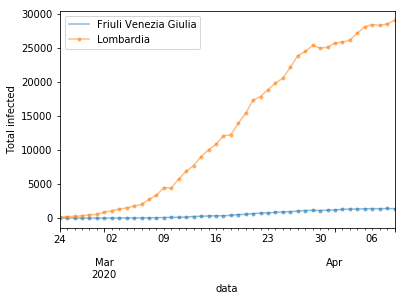

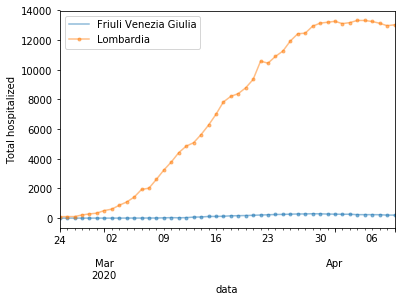

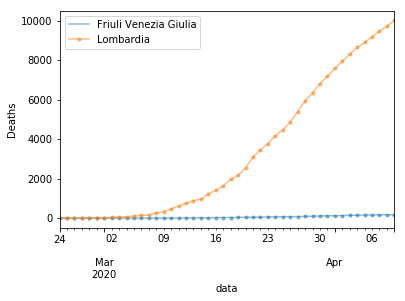

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

#axes = Lom.plot(marker=".", alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
#for ax in axes:
#    ax.set_ylabel('Total number')
axes = Lom.groupby('denominazione_regione')['totale_positivi'].plot(marker=".", alpha=0.5, legend=True) #linestyle='None') #, figsize=(11, 9), subplots=True)
plt.ylabel('Total infected')
plt.show()
axes = Lom.groupby('denominazione_regione')['totale_ospedalizzati'].plot(marker=".", alpha=0.5, legend=True) #linestyle='None') #, figsize=(11, 9), subplots=True)
plt.ylabel('Total hospitalized')
plt.show()
axes = Lom.groupby('denominazione_regione')['deceduti'].plot(marker=".", alpha=0.5, legend=True) #linestyle='None') #, figsize=(11, 9), subplots=True)
plt.ylabel('Deaths')
plt.show()

## Modeling in Pyomo

### Model for linear regression in L_2 = sum of squares = least squares method =  
### Model for linear regression in L_1 = linear programming problem 

$$
\min_{a,b} \sum | y_i - (ax_i+b) |
$$

In [ ]:
# corona_estimation.py
from pyomo.environ import *

model = ConcreteModel()

model.S_SI = Lom.index # Set(ordered=True)
model.P_REP_CASES = Lom["totale_positivi"] # Param(model.S_SI)
model.P_POP = 60000000   # Param()

model.I = Var(model.S_SI, bounds=(0,model.P_POP), initialize=1)
model.S = Var(model.S_SI, bounds=(0,model.P_POP), initialize=300)
model.beta = Var(bounds=(0.05, 70))
model.alpha = Var(bounds=(0.5, 1.5))
model.eps_I = Var(model.S_SI, initialize=0.0)


def _objective(model):
    return sum((model.eps_I[i])**2 for i in model.S_SI)
model.objective = Objective(rule=_objective, sense=minimize)

def _InfDynamics(model, i): 
    if i != 1:
        return model.I[i] == (model.beta * model.S[i-1] * model.I[i-1]**model.alpha)/model.P_POP
    return Constraint.Skip

model.InfDynamics = Constraint(model.S_SI, rule=_InfDynamics)

def _SusDynamics(model, i): 
    if i != 1:
        return model.S[i] == model.S[i-1] - model.I[i] 
    return Constraint.Skip
model.SusDynamics = Constraint(model.S_SI, rule=_SusDynamics)

def _Data(model, i):
    return model.P_REP_CASES[i] == model.I[i]+model.eps_I[i]
model.Data = Constraint(model.S_SI, rule=_Data)

def pyomo_postprocess(options=None, instance=None, results=None):
    print(’ ***’)
    print(’ *** Optimal beta Value: %.2f’ % value(instance.beta))
    print(’ *** Optimal alpha Value: %.2f’ % value(instance.alpha)) 
    print(’ ***’)